In [14]:
from objVAE import vae, fg, bg_single
import numpy as np
from glob import glob
import tifffile
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage
import torch
import h5py
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [29]:
import tifffile

x_crop = 256
y_crop = 256

paths = r'/data/mp_mpa/microtubule-sn7-low/*.tif'
paths_sorted = sorted(glob(paths))

images = [
    tifffile.imread(path) for path in paths_sorted
]
 
images = np.array(images)

images_array = []
for i in range(images.shape[1] // x_crop):
    for j in range(images.shape[2] // y_crop):
        images_array.append(images[:, (i)*x_crop:(i+1)*x_crop, (j)*y_crop:(j+1)*y_crop])


images = np.concatenate(images_array, axis=0)

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(0, 1, 2), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=1)

print(training_images.shape)

torch.Size([400, 1, 256, 256])


In [30]:
train, test = torch.utils.data.random_split(training_images, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=False)

In [31]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, presence, bg, fgs, xy, latents_fg, kl_bg, kl_fg = model(x)
    fg1, fg2 = fgs[:2]
    print(xy.shape, presence.shape)
    alpha = presence[0].detach().cpu().numpy() > 0.25
    xy = xy.detach().cpu().numpy()[0, alpha]

    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolor="r", facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    
    plt.subplot(2, 2, 3)
    plt.imshow(
        fg1[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 1")
    
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        fg2[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 2")

    return plt

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'none',
    'decoder_depth': 5,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'none',
    'encoder_depth': 4,
    'hidden_dim': 12,
    'position_dim': 100
}

fg_params = {
    'decoder_activation': 'mish',
    'decoder_feature_size': 56,
    'decoder_norm': 'none',
    'decoder_norm_first': True,
    'decoder_num_layers': 4,
    'glimpse_size': 16,
    'latent_dim': 5, # x, y, z, alpha, alpha^-1
    'position_embedding': 'radial',
    'position_prediction_scale': 1,
    'position_representation_scale': 1,
    'position_embedding_dim': 1,
    'num_entities': 30,
    'encoder_depth': 3,
    'topk_select_method': "max"
}

fg_model = fg.objFG(**fg_params)
bg_model = bg.objBG(in_channels=1,image_size=128, **bg_params)
model = objVAE.objVAE(bg_model=bg_model, fg_model=fg_model, beta=1e-9, learning_rate=8e-4)

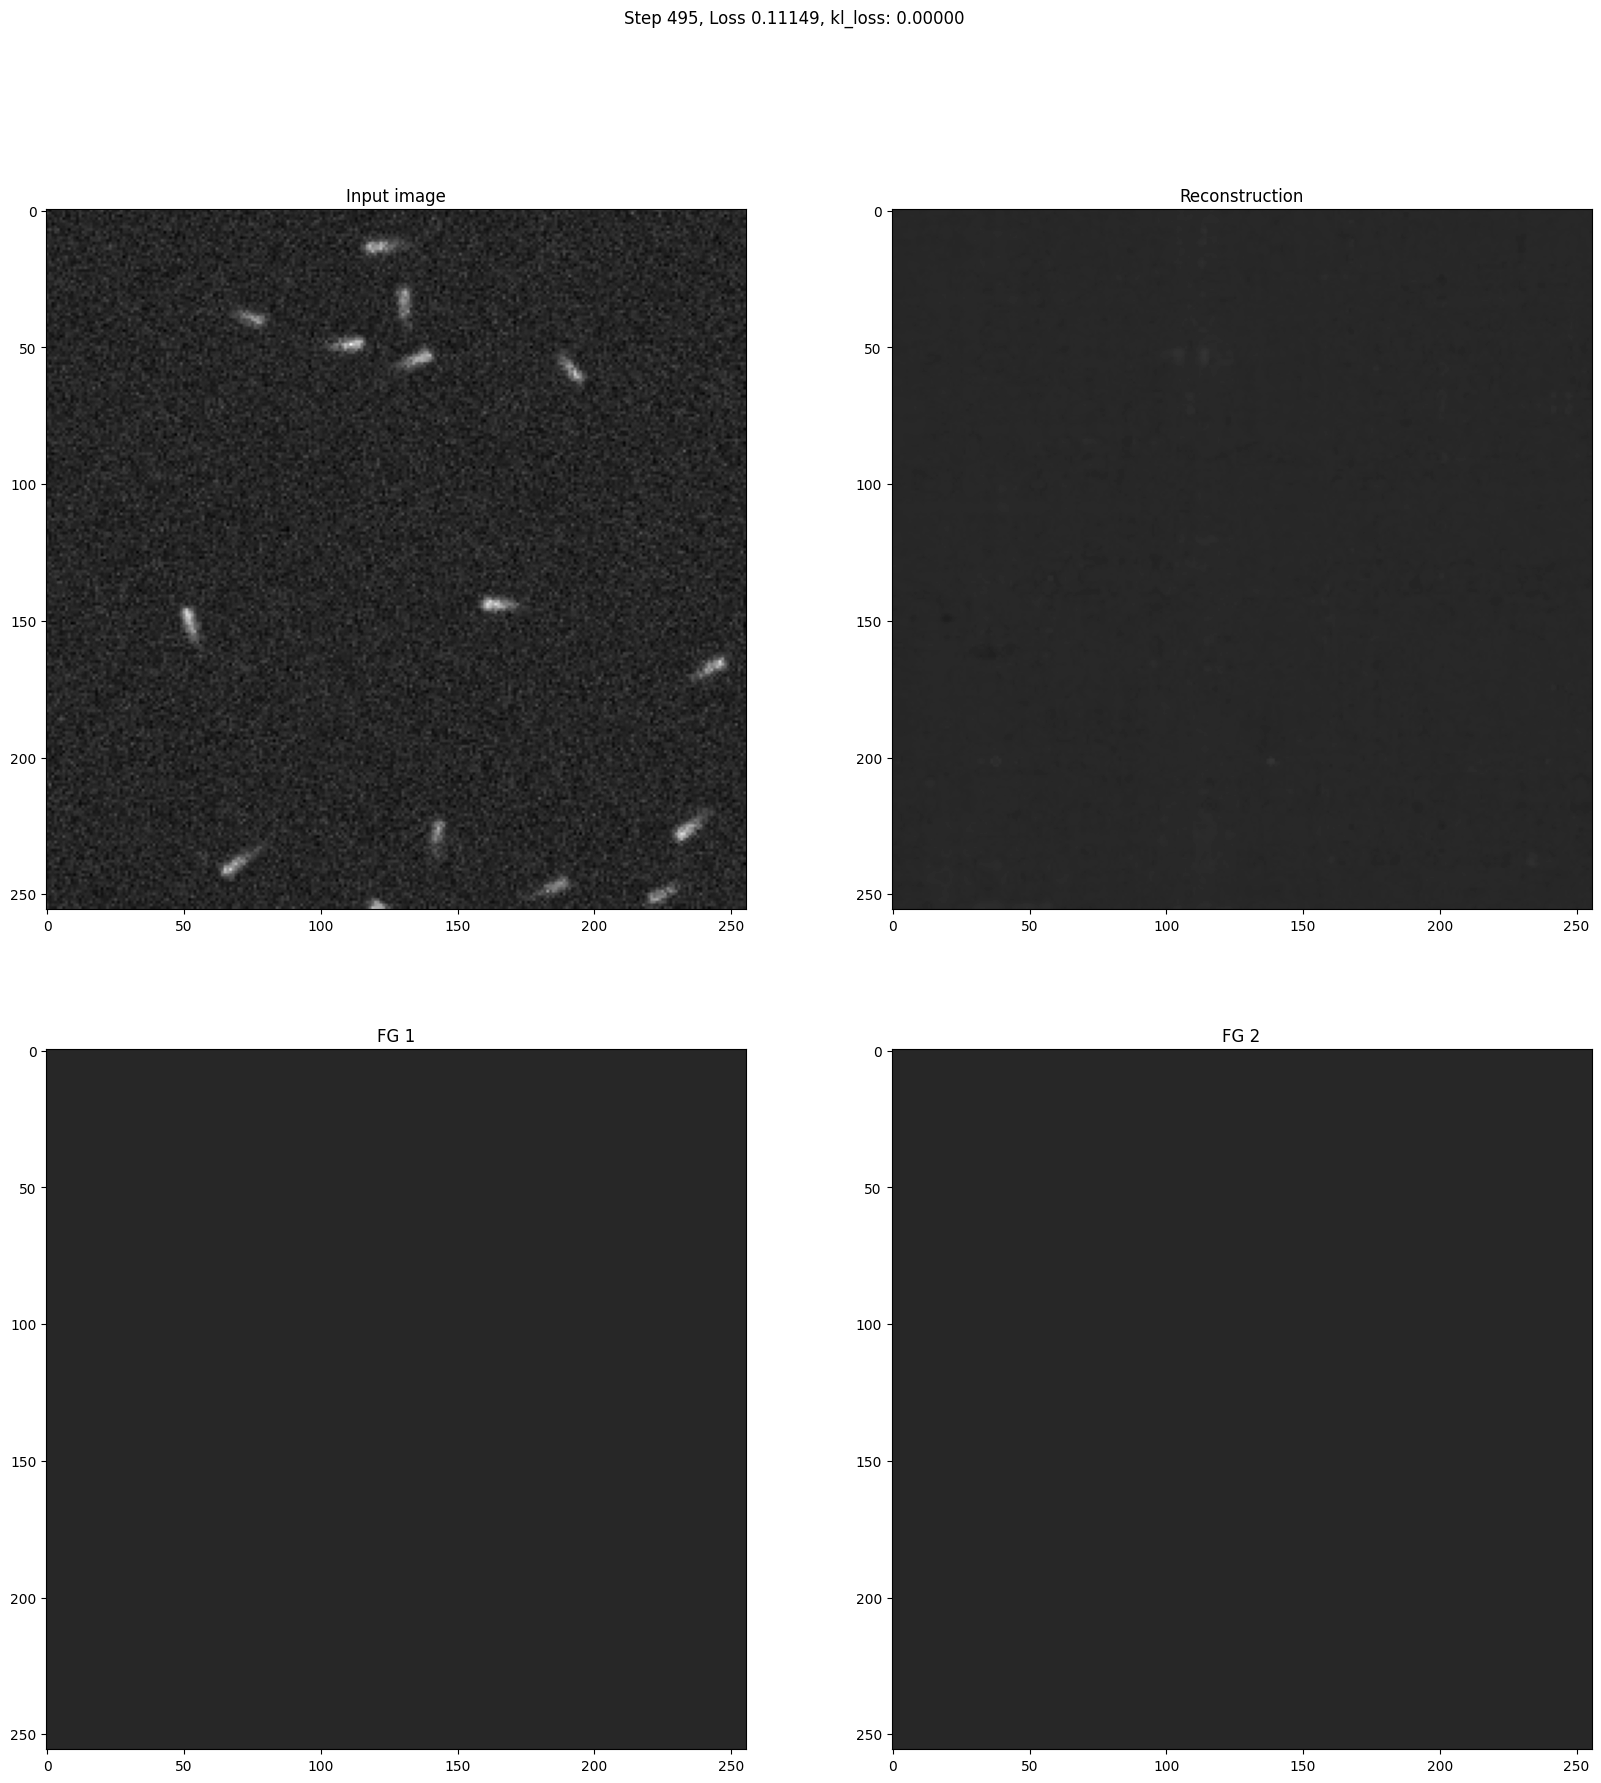

Epoch 11:  98%|█████████▊| 44/45 [00:01<00:00, 22.46it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [32]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
import pytorch_lightning as pl
import optuna

max_steps = 20000

# Annealing beta (weighting of kl-term of loss) helps 
# avoid mode collapse where every parameter is unit gaussian.
beta_annealing_end = 1800

# Annealing learning rate helps push the ELBO pareto frontier
lr_annealing_end = max_steps

# KL importance annealing makes the network sample latents based on
# residual error from background model early in training, to increase
# stability
kl_annealing_end = 2400

# Presence annealing biases the network towards saying that a latent is
# an object early in training (to avoid collapse where nothing is a object)
# and biases towards saying latents are not an object late in training
# (to avoid multiple detections of the same objects)
presence_annealing_end = 1000

class PlottingCallback(pl.Callback):


    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:

        
        loss = trainer.callback_metrics["reconstruction_epoch"]
        kl = trainer.callback_metrics["kl_epoch"]
        plot(model, train_loader)
        plt.suptitle(f"Step {trainer.global_step}, Loss {loss:.5f}, kl_loss: {kl:.5f}")
        ipd.clear_output(wait=True)
        plt.show()

        
def beta_annealing(step):
    logs = np.logspace(-4, -2.5, beta_annealing_end)
    if step >= beta_annealing_end:
        return logs[-1]
    else:
        return logs[int(step)]

def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0

    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def presence_bias_annealing(step):
    logs = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return logs[step]
    else:
        return 0
    
class Annealing(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        step = trainer.global_step
        
        pl_module.beta = beta_annealing(step)
        pl_module.fg_model.kl_importance = kl_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.presence_bias = presence_bias_annealing(step)

trainer = pl.Trainer(
    gpus=1,
    max_steps=max_steps,
    callbacks=[PlottingCallback(), Annealing()],
    logger=False,
#     check_val_every_n_epoch=1000,
)

# model.fg_model.topk_select_method = "random"
trainer.fit(model, train_loader)

# evaluate
test_results = trainer.test(model, test_loader)